# Predicción Lluvia en Australia

La tarea es desarrollar un modelo de aprendizaje que prediga de manera binaria (sí/no) si el día de mañana lloverá (columna RainTomorrow) en una o varias de las ciudades australianas que existen en los datos (columna Location).

In [1]:
!pip install geopy==2.2.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

from geopy.geocoders import Nominatim
import time
import math

#from mlp_toolkits.Basemap.test import Basemap

## Análisis Exploratorio de Datos

In [3]:
# Importar el dataset (.csv)

rain = pd.read_csv('/work/weatherAUS.csv')
rain.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
#Observar las dimensiones del dataset
rain.shape

(145460, 23)

El dataset tiene 145460 registros y 23 variables.

In [5]:
#Observar los nombres de las columnas
col_names = rain.columns
col_names

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [6]:
#Observar información general del dataset
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Información importante con respecto al dataset: 
- Hay valores que faltan en el conjunto de datos
- El conjunto de datos incluye valores numéricos y categóricos (float64 y object)

In [7]:
#Observar las propiedades estadisticas de las variables numericas del dataset
rain.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [8]:
rain.describe().shape

(8, 16)

In [9]:
#Observar las propiedades estadisticas de las variables categoricas del dataset
rain.describe(include=['object'])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2015-04-06,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [10]:
rain.describe(include=['object']).shape

(4, 7)

- Existen 16 variables numericas, 7 categoricas y 1 correspondiente a la fecha.
- El conjunto de datos incluye valores numéricos y categóricos (float64 y object)
- La variable objetivo es RainTomorrow

Se procede a depurar el dataset eliminando los registros con valores faltantes

In [11]:
#Buscar la cantidad de registros con datos faltantes
rain.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [12]:
#Remover todas las filas que presenten datos nulos
rain.dropna(subset=['RainTomorrow'],inplace = True)
#rain.reset_index(drop=True,inplace=True)

In [13]:
rain.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

### Variable Objetivo

Ahora se observa la variable objetivo

In [14]:
#Frecuencia en la variable objetivo
rain['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [15]:
#Porcentaje de frecuencia en la variable objetivo
rain['RainTomorrow'].value_counts()/len(rain)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

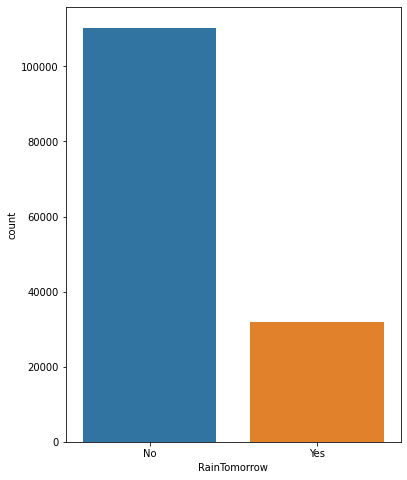

In [16]:
#Grafico la frecuencia de la variable objetivo
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=rain)
plt.show()

Los registros se encuentras distribuidos de la siguiente forma: No=110316(77.5819%) y Yes=31877(22.4181%)

### Variables Numericas

In [17]:
numerical = rain.describe().columns
numerical

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')

In [18]:
rain[numerical].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7


In [19]:
rain[numerical].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

In [20]:
rain[numerical].nunique()

MinTemp          389
MaxTemp          505
Rainfall         679
Evaporation      356
Sunshine         145
WindGustSpeed     67
WindSpeed9am      43
WindSpeed3pm      44
Humidity9am      101
Humidity3pm      101
Pressure9am      546
Pressure3pm      549
Cloud9am          10
Cloud3pm          10
Temp9am          440
Temp3pm          500
dtype: int64

Se presentan valores faltantes, por lo tanto es necesario tratarlos.

### Variables Categoricas

In [21]:
categorical = rain.describe(include=['object']).columns
categorical 

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')

In [22]:
rain[categorical].head()


,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


In [23]:
rain[categorical].isnull().sum()

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

In [24]:
rain[categorical].nunique()

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

La variable Date tiene gran cantidad de registros unicos, por lo que es necesario realizar un preprocesamiento.

In [25]:
rain['Date'] = pd.to_datetime(rain['Date'])

In [26]:
rain['Year'] = rain['Date'].dt.year
rain['Month'] = rain['Date'].dt.month
rain['Day'] = rain['Date'].dt.day
rain.drop('Date', axis=1, inplace = True)

fechas = pd.concat([rain['Year'], rain['Month'],rain['Day']], axis=1)
fechas.head()

,Year,Month,Day
0,2008,12,1
1,2008,12,2
2,2008,12,3
3,2008,12,4
4,2008,12,5


In [27]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

In [28]:
Ciudades = rain.Location.unique()
Ciudades

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [29]:
rain.Location.value_counts()


Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Ballarat            3028
Launceston          3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cobar               2988
Cairns              2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
NorfolkIsland       2964
Penrith             2964
SalmonGums          2955
Newcastle           2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


Es necesario convertir variables categoricas en numericas, esto se realiza con el método One Hot Encoding.

In [30]:
pd.get_dummies(rain.Location, drop_first=True).head()

,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
rain.WindGustDir.value_counts()

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64

In [32]:
pd.get_dummies(rain.WindGustDir, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [33]:
rain.WindDir9am.value_counts()

N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: WindDir9am, dtype: int64

In [34]:
pd.get_dummies(rain.WindDir9am, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
rain.WindDir3pm.value_counts()

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64

In [36]:
pd.get_dummies(rain.WindDir3pm, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [37]:
rain.RainToday.value_counts()

No     109332
Yes     31455
Name: RainToday, dtype: int64

In [38]:
pd.get_dummies(rain.RainToday, drop_first=True, dummy_na=True).head()

,Yes,NaN
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


## Visualización efectiva de Datos

In [39]:
#Mostrar el tamaño del dataset filtrado con el que se va a trabajar el proyecto
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Indicator(mode = "number", value = df_filtrado.shape[0], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🧾 Rows<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
fig.add_trace(go.Indicator(mode = "number", value = df_filtrado.shape[1], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "⭕ Columns<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
fig.show()

NameError: name 'df_filtrado' is not defined

In [ ]:
Ciudades.tolist()

['Albury',
 'BadgerysCreek',
 'Cobar',
 'CoffsHarbour',
 'Moree',
 'Newcastle',
 'NorahHead',
 'NorfolkIsland',
 'Penrith',
 'Richmond',
 'Sydney',
 'SydneyAirport',
 'WaggaWagga',
 'Williamtown',
 'Wollongong',
 'Canberra',
 'Tuggeranong',
 'MountGinini',
 'Ballarat',
 'Bendigo',
 'Sale',
 'MelbourneAirport',
 'Melbourne',
 'Mildura',
 'Nhil',
 'Portland',
 'Watsonia',
 'Dartmoor',
 'Brisbane',
 'Cairns',
 'GoldCoast',
 'Townsville',
 'Adelaide',
 'MountGambier',
 'Nuriootpa',
 'Woomera',
 'Albany',
 'Witchcliffe',
 'PearceRAAF',
 'PerthAirport',
 'Perth',
 'SalmonGums',
 'Walpole',
 'Hobart',
 'Launceston',
 'AliceSprings',
 'Darwin',
 'Katherine',
 'Uluru']

In [ ]:
#¿Donde están ubicadas las viviendas?
# Crear Objeto Nominatim
geolocator = Nominatim(user_agent="AppMap")#

location_lista = ['Albury','Badgerys Creek','Cobar','Coffs Harbour','Moree','Newcastle','Norah Head','Norfolk Island','Penrith',
 'Richmond','Sydney','Sydney Airport','Wagga Wagga','Williamtown','Wollongong','Canberra','Tuggeranong','Mount Ginini','Ballarat',
 'Bendigo','Sale','Melbourne Airport','Melbourne','Mildura','Nhil','Portland','Watsonia','Dartmoor','Brisbane','Cairns','GoldCoast',
 'Townsville','Adelaide','Mount Gambier','Nuriootpa','Woomera','Albany','Witchcliffe','Pearce RAAF','Perth Airport','Perth','SalmonGums',
 'Walpole','Hobart','Launceston','Alice Springs','Darwin','Katherine','Uluru']

#Recorremos la lista
for i in location_lista:
    address = geolocator.geocode(i, timeout=10)
    #print ("Ciudad de "+ i + " : " + str(address.longitude) + "," + str(address.latitude))
    #print ("Ciudad de "+ i)
    time.sleep(1)

In [ ]:
#Dimensiónd de la figura
plt.figure(figsize=(16,12))

#Distribución lines costeras
eq_map=Basemap(projection='robin',lon_0=0,lat_0=0)
#Dibujar lineas costeras y paises
eq_map.drawcoastlines()
eq_map.drawcountries()
#Definir colores
eq_map.fillcontinents(color="brown")
eq_map.drawmapboundary(fill_color="aqua")

for i in location_lista:
    address = geolocator.geocode(i, timeout=2)    
    time.sleep(0.5)
    x,y = eq_map(address.longitude,address.latitude)
    eq_map.plot(x,y, color= 'g',marker='o', markersize=17, alpha=0.8)

NameError: name 'Basemap' is not defined

<Figure size 1152x864 with 0 Axes>

In [ ]:
#Generar el mapa original
m_5 = folium.Map(location=[5.170035, -74.914305], tiles='cartodbpositron', zoom_start=6)

# Añadir el mapa de calor con las cordenadas al mapa original
HeatMap(data=df_filtrado[['lat', 'lon']], radius=10).add_to(m_5)

# Mostrar el mapa
m_5

## Ingeniería de características

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0fa0bc36-8b95-4938-8cdb-b0779e978154' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>